# MNIST digit classification with Convolutional Neural Network (CNN)

In another notebook, MNIST_PyTorch-NN, we built an artificial neural network with PyTorch to classify MNIST images of hand drawn digits. In this notebook, we will build a convolutional neural network (CNN) with PyTorch to classify these images. As before, our task is to recognize digits from $0$ to $9$ from the <b>MNIST dataset</b>, which consists of $28 \times 28$ greyscale images.

In [2]:
import torch
import torchvision
from torch.utils.data import DataLoader, Subset, random_split
import torch.nn as nn
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np

## Load dataset and prepare data loaders:

In [3]:
image_path = './'
transform = transforms.Compose([transforms.ToTensor()])
# We use the ToTensor() method to convert the pixel features (i.e. values from 0 to 255) into a tensor and normalizes to [0, 1] range

mnist_dataset = torchvision.datasets.MNIST(root=image_path, train=True, transform=transform, download=True)

In [12]:
mnist_dataset.data.shape  # mnist_dataset consists of 60000 images of size 28x28

torch.Size([60000, 28, 28])

Note: the torchvision MNIST dataset does not have separate a validation set, so we will use a subset of the training data as the validation set. We will have $50000$ samples in the train set, $10000$ in the validation set, and $10000$ in the test set. 

In [4]:
mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000))
mnist_train_dataset = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))
mnist_test_dataset =  torchvision.datasets.MNIST(root=image_path, train=False, transform=transform, download=False)

In [5]:
batch_size = 64
torch.manual_seed(1)

train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle=False)

In [14]:
next(iter(train_dl))[0].shape   # Each minibatch in train_dl contains 64 samples of dimension (1, 28, 28) (1 channel)

torch.Size([64, 1, 28, 28])

## Example images from MNIST dataset

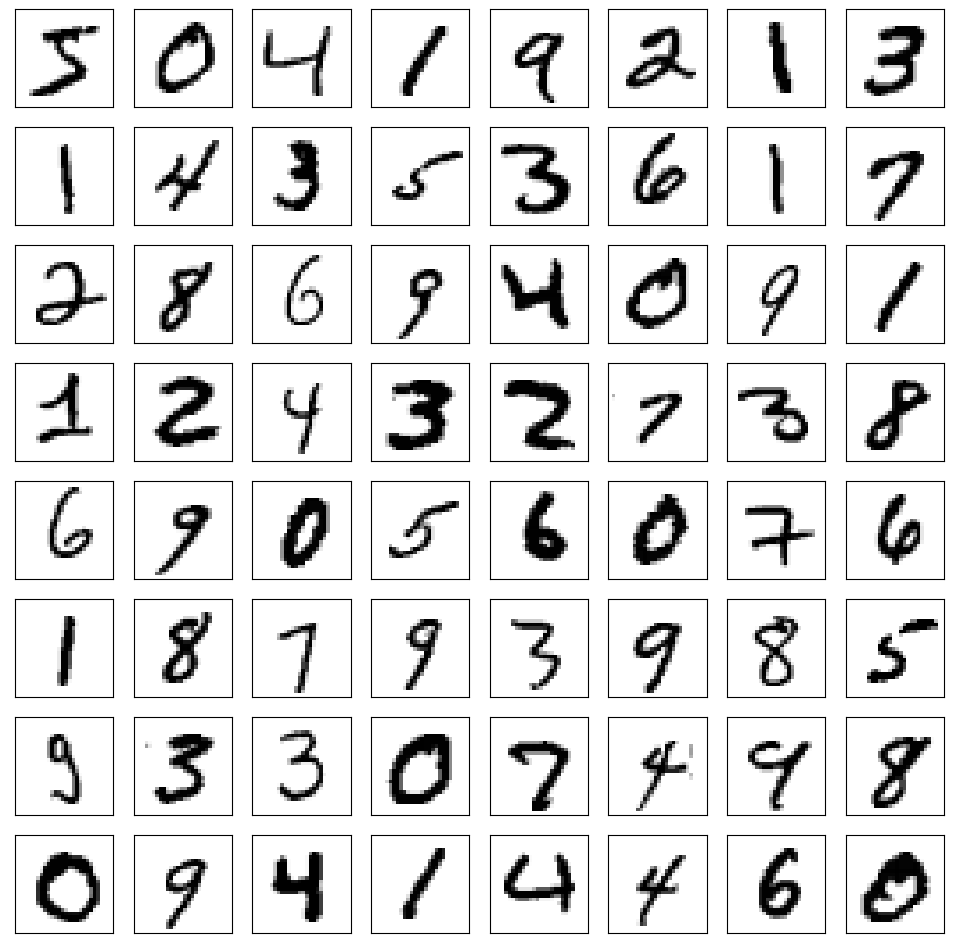

In [17]:
fig, axs = plt.subplots(8, 8, figsize=(12, 12))
index = 0

for i in range(8):
    for j in range(8):

        axs[i, j].imshow(mnist_dataset.data[index], cmap="binary")
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        index += 1

## Constructing a CNN using nn.Sequential

In [19]:
model = nn.Sequential(

    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(3136, 1024),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(1024, 10)
    
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    

## Training model

In [20]:
def train(model, num_epochs, train_dl, valid_dl):
    
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    
    for epoch in range(num_epochs):
        
        model.train()
        
        for x_batch, y_batch in train_dl:
            
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum()
        
        
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        
        with torch.no_grad():
            
            for x_batch, y_batch in valid_dl:
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()
                
        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f}    val_accuracy: {accuracy_hist_valid[epoch]:.4f} ')
        
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [21]:
torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.9497    val_accuracy: 0.9776 
Epoch 2 accuracy: 0.9837    val_accuracy: 0.9862 
Epoch 3 accuracy: 0.9887    val_accuracy: 0.9859 
Epoch 4 accuracy: 0.9914    val_accuracy: 0.9888 
Epoch 5 accuracy: 0.9930    val_accuracy: 0.9860 
Epoch 6 accuracy: 0.9940    val_accuracy: 0.9901 
Epoch 7 accuracy: 0.9954    val_accuracy: 0.9886 
Epoch 8 accuracy: 0.9954    val_accuracy: 0.9897 
Epoch 9 accuracy: 0.9967    val_accuracy: 0.9899 
Epoch 10 accuracy: 0.9969    val_accuracy: 0.9898 
Epoch 11 accuracy: 0.9964    val_accuracy: 0.9920 
Epoch 12 accuracy: 0.9974    val_accuracy: 0.9881 
Epoch 13 accuracy: 0.9973    val_accuracy: 0.9889 
Epoch 14 accuracy: 0.9977    val_accuracy: 0.9920 
Epoch 15 accuracy: 0.9973    val_accuracy: 0.9905 
Epoch 16 accuracy: 0.9980    val_accuracy: 0.9905 
Epoch 17 accuracy: 0.9982    val_accuracy: 0.9905 
Epoch 18 accuracy: 0.9978    val_accuracy: 0.9912 
Epoch 19 accuracy: 0.9984    val_accuracy: 0.9893 
Epoch 20 accuracy: 0.9987    val_accurac

Let's look at both the loss and accuracy during the training phase:

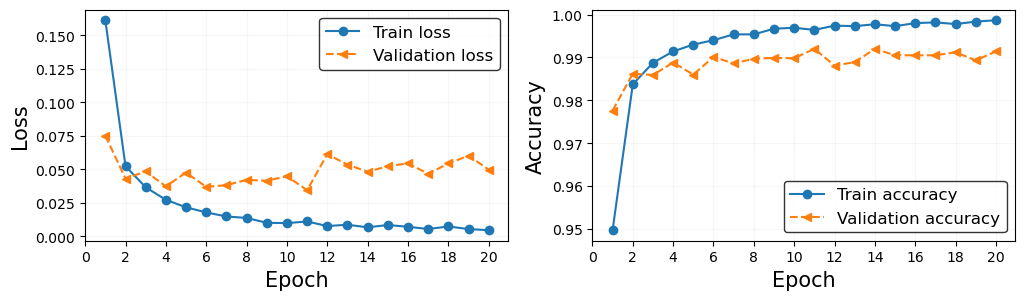

In [30]:
x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.legend(fontsize=12, frameon=True, edgecolor='k')
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xticks(np.arange(0, 22, 2))
ax.set_ylabel('Loss', fontsize=15)
ax.grid(alpha=0.1)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train accuracy')
ax.plot(x_arr, hist[3], '--<', label='Validation accuracy')
ax.legend(fontsize=12, frameon=True, edgecolor='k')
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xticks(np.arange(0, 22, 2))
ax.set_ylabel('Accuracy', fontsize=15)
ax.grid(alpha=0.1)
plt.show()

## Evaluate performance on test set

In [31]:
mnist_test_dataset.data.shape  # Test dataset has 10000 images of size 28x28

torch.Size([10000, 28, 28])

In [33]:
test_data = mnist_test_dataset.data.unsqueeze(1)    # Unsqueeze to add channel dimension (1 channel)
test_data.shape

torch.Size([10000, 1, 28, 28])

In [34]:
test_pred = model(test_data / 255.)
is_correct = (torch.argmax(test_pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}')

Test accuracy: 0.9922


Our CNN has achieved an accuracy of $99.22\%$ on the test dataset! This is an improvement over our previous best result with a regular NN architecture ($97.86\%$).

## Displaying test set images and the model prediction 

Let's now display a selection of images from the test set, and our predicted digit (shown in blue in the bottom-right corner).

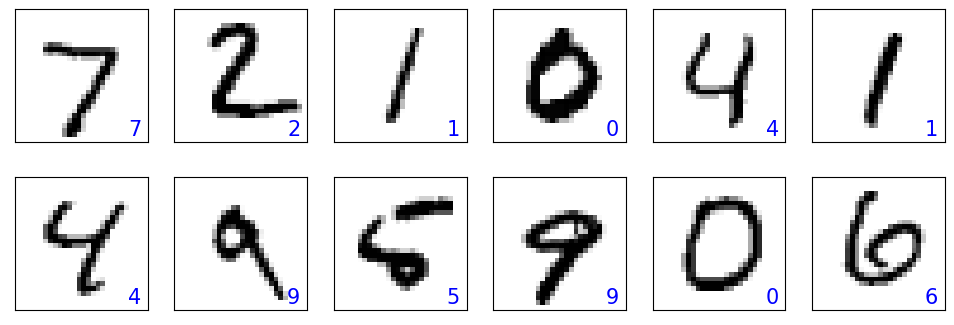

In [35]:
fig = plt.figure(figsize=(12, 4))

for i in range(12):
    
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    
    image = mnist_test_dataset[i][0][0, :, :]    # (28, 28) tensor
    image_fix = image.unsqueeze(0).unsqueeze(1)  # (1, 1, 28, 28) tensor (in NCHW format for CNN)
    pred = model(image_fix)
    y_pred = torch.argmax(pred)
    
    ax.imshow(image, cmap='binary')
    ax.text(0.9, 0.1, y_pred.item(), size=15, color='blue', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    
plt.show()
    
